# SIDM Fits

In [1]:
import numpy as np
from matplotlib import pyplot as plt
#import emcee
import PlotSettings as ps
from PlotSettings import plt, MainColor1, MainColor2, BackgroundColor1, BackgroundColor2, Gray1, Gray2
import LatexSettings
import Constants
from CrossSections import sigv_T

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Fits

Import data

In [3]:
#Thesis_path = 'D:/Nicolás/Documents/Research/Masters-Thesis/Thesis Repo/Thesis-Repo/'
Thesis_path = '/home/nicolas/Documents/Research/Masters-Thesis/Thesis Repo/Thesis-Repo/'

DwarfData = np.loadtxt(Thesis_path+'DarkMatter/DarkMatterData/DwarfDataPlot.csv', delimiter='\t')

"""
////////////// Load Data //////////////////
"""


#for the plots
DwarfData = np.loadtxt(Thesis_path+'DarkMatter/DarkMatterData/DwarfDataPlot.csv', delimiter='\t')
Dwarf_x =     DwarfData[:,0]
Dwarf_y =     DwarfData[:,1]
Dwarf_Err_l = DwarfData[:,2]
Dwarf_Err_r = DwarfData[:,3]
Dwarf_Err_d = DwarfData[:,4]
Dwarf_Err_u = DwarfData[:,5]

GalaxyData = np.loadtxt(Thesis_path+'DarkMatter/DarkMatterData/GalaxyDataPlot.csv', delimiter='\t')
Galaxy_x = GalaxyData[:,0]
Galaxy_y = GalaxyData[:,1]
Galaxy_Err_l = GalaxyData[:,2]
Galaxy_Err_r = GalaxyData[:,3]
Galaxy_Err_d = GalaxyData[:,4]
Galaxy_Err_u = GalaxyData[:,5]

ClusterData = np.loadtxt(Thesis_path+'DarkMatter/DarkMatterData/ClusterDataPlot.csv', delimiter='\t')
Cluster_x = ClusterData[:,0]
Cluster_y = ClusterData[:,1]
Cluster_Err_l = ClusterData[:,2]
Cluster_Err_r = ClusterData[:,3]
Cluster_Err_d = ClusterData[:,4]
Cluster_Err_u = ClusterData[:,5]

# For the fit
OrderedData = np.loadtxt(Thesis_path+'DarkMatter/DarkMatterData/Datos_ordenados.csv')
x_data = OrderedData[:,0]
y_data = OrderedData[:,1]
err_x_data = OrderedData[:,2]
err_y_data = OrderedData[:,3]


MCMC Fit functions

In [61]:


"""
////////////// Functions for the Fit //////////////////
"""
#Useful functions to use emcee
class mcmc_res:
    def __init__(self, sampler, x0=None):
        self.sampler = sampler
        self.flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
        self.x = []
        self.x_low = []
        self.x_high = []
        self.ndim = self.flat_samples.shape[1]
        for i in range(self.ndim):
            mcmc = np.percentile(self.flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            self.x.append(mcmc[1])
            self.x_low.append(q[0])
            self.x_high.append(q[1])
        self.x0 = x0
        self.nonmarg_bestfit = sampler.flatchain[np.argmin(sampler.flatlnprobability)]
        
def run_mcmc(func_chi2, x0=None, bounds=None, nstep=5000, args=()):    
    assert x0 is not None, 'please, provide a first guess of the parameter values'
    assert bounds is not None, 'please, provide the boundaries of the parameter hyperspace'    
    def log_prior(theta, bounds):
        theta_l = list(theta)
        for i, pp in enumerate(theta_l):
            if (pp < bounds[i][0]) | (pp > bounds[i][1]):
                return -np.inf
        return 0    
    def log_likelihood(theta, *args):
        return -0.5 * func_chi2(theta, *args)    
    def log_probability(theta, *args):
        lp = log_prior(theta, bounds)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, *args)    
    #import emcee    
    ndim = len(x0)
    nwalkers = 4 * ndim    
    pos = x0 + 1e-4 * np.random.randn(nwalkers, ndim)    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=args)
    sampler.run_mcmc(pos, nstep, progress=True)    
    result = mcmc_res(sampler, x0=x0) 
    # Autocorrelation time
    #tau = sampler.get_autocorr_time()
    #print(tau)
    return result


# Define a chi square distribution to use as input in emcee
def compute_chi2(free_params, x=None, data=None, err=None):
    #Compute model
    lg, lM, lm = free_params
    g, M, m = pow(10,lg), pow(10, lM), pow(10, lm)
    model = [sigv_T(x, g, M, m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2x + chi2y




### First Fit:

Three input parameters with dSph, LSB and Cluster Data 

Maximum likelihood

In [29]:
from scipy.optimize import minimize


g1, M1, m1 = 3e-2, 5e-3, 5
l_g1 = np.log10(g1)
l_M1 = np.log10(M1)
l_m1 = np.log10(m1)

initial = [l_g1, l_M1, l_m1]


soln = minimize(compute_chi2, initial, args=(x_data, y_data, (err_x_data, err_y_data)) )

log_g_ml, log_M_ml, log_m_ml = soln.x

print("Maximum likelihood estimates:")
print("log g = {0:.3f}".format(log_g_ml))
print("log M = {0:.3f}".format(log_M_ml))
print("log m = {0:.3f}".format(log_m_ml))

C:\Users\Nicolás\AppData\Local\Temp\ipykernel_27080\2370661484.py:60: RuntimeWarning: overflow encountered in square
  chi2y= np.sum((data-model)**2/erry**2)
c:\Users\Nicolás\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Nicolás\AppData\Local\Temp\ipykernel_27080\2370661484.py:60: RuntimeWarning: overflow encountered in square
  chi2y= np.sum((data-model)**2/erry**2)


Maximum likelihood estimates:
log g = -1.082
log M = -2.595
log m = 0.552


Run MCMC

In [30]:
#Priors and log priors
g1, M1, m1 = 8e-3, 2e-3, 5
l_g1 = np.log10(g1)
l_M1 = np.log10(M1)
l_m1 = np.log10(m1)

# emcee arguments
ndim = 3 
nwalkers = 48
nstep = 5000

params_guess = [l_g1, l_M1, l_m1]
bounds_eg = [[-5, -1], [-3, 0], [-5, 4]]
data_args = (x_data, y_data, (err_x_data, err_y_data))

bf1 = run_mcmc(compute_chi2, x0 = params_guess, bounds=bounds_eg, args=data_args, nstep=nstep)


#Extract parameters from the best fit value
lg_f1, lM_f1, lm_f1 = bf1.x
g_f1, M_f1, m_f1 = pow(10,lg_f1), pow(10, lM_f1), pow(10, lm_f1)


print('g = ', g_f1, '\n'
      'M = ', M_f1, '\n'
      'm = ', m_f1, '\n')



100%|██████████| 5000/5000 [20:23<00:00,  4.09it/s]

g =  0.048114798474444435 
M =  0.002075069252076996 
m =  0.6802312494880876 



Corner plot for the fit

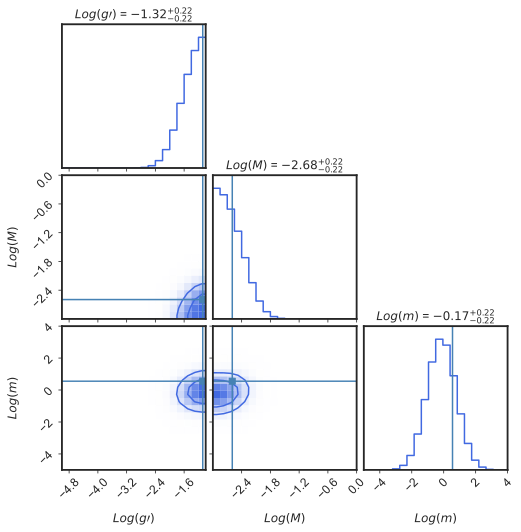

In [31]:
# Corner plot

import corner

truth = [log_g_ml, log_M_ml, log_m_ml]

labels = [r'$Log(g\prime) $', r'$Log(M)$', r'$Log(m)$']

figure = corner.corner(
            bf1.flat_samples, labels=labels, title_kwargs={"fontsize": 12}, 
            label_kwargs={"fontsize": 12}, smooth=2, smooth1d=2, truths=truth,
            range=bounds_eg, color='royalblue',
            levels=(0.39,0.68), plot_datapoints=False, show_titles=True
        )



In [32]:
from IPython.display import display, Math

linear_labels = [r'$(gp) $', r'$Log(M)$', r'$Log(m)$']
Params_fit = [g_f1, M_f1, m_f1]
Params_fit_R = [0, 0, 0]
Params_fit_L = [0, 0, 0]
ndim=3

for i in range(ndim):
    #Extract central value and percentiles 16, 84
    mcmc = np.percentile(bf1.flat_samples[:, i], [16, 50, 84])

    #Linearize
    lin_mcmc = pow(10, mcmc[1])
    Params_fit[i] = lin_mcmc

    #Define quantiles (uncertainty)

    #Propagate uncertainty to linear parameters
    q = np.diff(mcmc)
    #print(q)
    
    lin_q = lin_mcmc*np.log(10)*q
    Params_fit_L[i] = lin_q[0] 
    Params_fit_R[i] = lin_q[1]
    #Linear central values

    #Print linear values and uncertainties
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(lin_mcmc, lin_q[0], lin_q[1],labels[i])
    display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Compute the $\chi^2$ of the fit

In [37]:
compute_chi2(Params_fit, x=x_data, data=y_data, err=(err_x_data*60, err_y_data*80))

522.8518545873518

### Second Fit

Three parameters, only dSph and LSB data. Cluster data would be taken as a constraint.

In [55]:
#Exclude cluster data
x_data2 = x_data[0:12]
y_data2 = y_data[0:12]
err_x_data2 = err_x_data[0:12]
err_y_data2 = err_y_data[0:12]

In [47]:

g2, M2, m2 = 3e-2, 5e-3, 5
l_g2 = np.log10(g2)
l_M2 = np.log10(M2)
l_m2 = np.log10(m2)

initial = [l_g2, l_M2, l_m2]


soln = minimize(compute_chi2, initial, args=(x_data, y_data, (err_x_data, err_y_data)) )

log_g_ml, log_M_ml, log_m_ml = soln.x

print("Maximum likelihood estimates:")
print("log g = {0:.3f}".format(log_g_ml))
print("log M = {0:.3f}".format(log_M_ml))
print("log m = {0:.3f}".format(log_m_ml))

C:\Users\Nicolás\AppData\Local\Temp\ipykernel_27080\2370661484.py:60: RuntimeWarning: overflow encountered in square
  chi2y= np.sum((data-model)**2/erry**2)
c:\Users\Nicolás\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Nicolás\AppData\Local\Temp\ipykernel_27080\2370661484.py:60: RuntimeWarning: overflow encountered in square
  chi2y= np.sum((data-model)**2/erry**2)


Maximum likelihood estimates:
log g = -1.085
log M = -2.597
log m = 0.557


In [48]:
#Priors and log priors
g2, M2, m2 = 8e-3, 2e-3, 5
l_g2 = np.log10(g2)
l_M2 = np.log10(M2)
l_m2 = np.log10(m2)

# emcee arguments
ndim = 3 
nwalkers = 48
nstep = 5000

params_guess = [l_g2, l_M2, l_m2]
bounds_eg = [[-5, -1], [-3, 0], [-5, 4]]
data_args = (x_data, y_data, (err_x_data, err_y_data))

bf2 = run_mcmc(compute_chi2, x0 = params_guess, bounds=bounds_eg, args=data_args, nstep=nstep)


#Extract parameters from the best fit value
lg_f2, lM_f2, lm_f2 = bf2.x
g_f2, M_f2, m_f2 = pow(10,lg_f2), pow(10, lM_f2), pow(10, lm_f2)


print('g = ', g_f2, '\n'
      'M = ', M_f2, '\n'
      'm = ', m_f2, '\n')


100%|██████████| 5000/5000 [06:14<00:00, 13.34it/s]

g =  0.04914262794469976 
M =  0.0020878221533674056 
m =  0.7598975791404886 



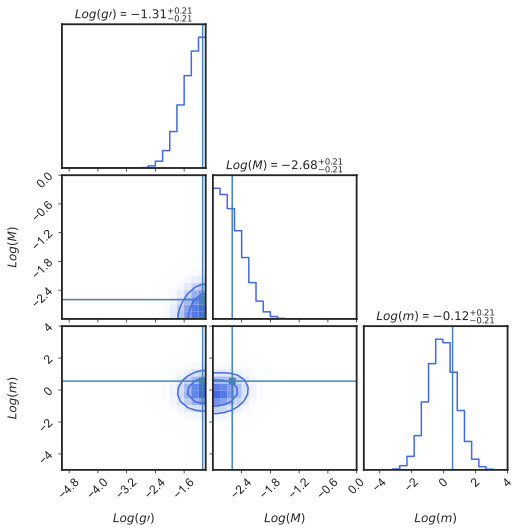

In [49]:
truth = [log_g_ml, log_M_ml, log_m_ml]

labels = [r'$Log(g\prime) $', r'$Log(M)$', r'$Log(m)$']

figure = corner.corner(
            bf2.flat_samples, labels=labels, title_kwargs={"fontsize": 12}, 
            label_kwargs={"fontsize": 12}, smooth=2, smooth1d=2, truths=truth,
            range=bounds_eg, color='royalblue',
            levels=(0.39,0.68), plot_datapoints=False, show_titles=True
        )


Comparison of both fits

### Third Fit 

Only two parameters. $M (\equiv m_{Z'}) $ is fixed to $50~\mathrm{MeV}$

In [59]:
g3, M, m3 = 3e-2, 5e-2, 5
l_g3 = np.log10(g3)
#l_M3 = np.log10(M3)
l_m3 = np.log10(m3)


def compute_chi2(free_params, x=None, data=None, err=None):
    #Compute model
    lg, lm = free_params
    g, m = pow(10,lg), pow(10, lm)
    model = [sigv_T(x, g, M, m) for x in x]

    errx, erry = err
    #chi2 computation
    chi2y= np.sum((data-model)**2/erry**2)
    chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
    return chi2x + chi2y


initial = [l_g3, l_m3]


soln = minimize(compute_chi2, initial, args=(x_data, y_data, (err_x_data, err_y_data)) )

log_g_ml,  log_m_ml = soln.x

#Priors and log priors
g3, M3, m3 = 8e-3, 5e-2, 5
l_g3 = np.log10(g3)
l_M3 = np.log10(M3)
l_m3 = np.log10(m3)

# emcee arguments
ndim = 2 
nwalkers = 48
nstep = 5000

params_guess = [l_g3, l_m3]
bounds_eg = [[-5, -1], [-5, 4]]
data_args = (x_data, y_data, (err_x_data, err_y_data))

bf3 = run_mcmc(compute_chi2, x0 = params_guess, bounds=bounds_eg, args=data_args, nstep=nstep)


#Extract parameters from the best fit value
lg_f3,  lm_f3 = bf3.x
g_f3, m_f3 = pow(10,lg_f3),  pow(10, lm_f3)


print('g = ', g_f3, '\n'
      'M = ', M, '\n'
      'm = ', m_f3, '\n')

C:\Users\Nicolás\AppData\Local\Temp\ipykernel_27080\1135073574.py:10: RuntimeWarning: overflow encountered in double_scalars
  g, m = pow(10,lg), pow(10, lm)
d:\Nicolás\Documents\Research\Masters-Thesis\Thesis Repo\Thesis-Repo\DarkMatter\CrossSections.py:215: RuntimeWarning: divide by zero encountered in double_scalars
  return Prefactor*Integral
d:\Nicolás\Documents\Research\Masters-Thesis\Thesis Repo\Thesis-Repo\DarkMatter\CrossSections.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  sigma_st = -Prefactor/2*( (16*m**2+2*M**2+ 3*s*v**2)/(s-M**2) - (4*m**2 + 2*m**2*(4*M**2+3*s*v**2+s ) + (M**2+s*v**2)**2 )/(s*v**2*(s-M**2))*np.log(1 + s*v**2/M**2) )
d:\Nicolás\Documents\Research\Masters-Thesis\Thesis Repo\Thesis-Repo\DarkMatter\CrossSections.py:195: RuntimeWarning: invalid value encountered in double_scalars
  sigma_st = -Prefactor/2*( (16*m**2+2*M**2+ 3*s*v**2)/(s-M**2) - (4*m**2 + 2*m**2*(4*M**2+3*s*v**2+s ) + (M**2+s*v**2)**2 )/(s*v**2*(s-M**2))*np.log(1 + s*v

g =  0.06651176941063283 
M =  0.05 
m =  0.027073374136028377 



### Fits Comparison 

In [63]:
chi1 = compute_chi2([g_f1, M_f1, m_f1], x=x_data, data=y_data, err=(err_x_data*80, err_y_data*80))
chi2 = compute_chi2([g_f2, M_f2, m_f2], x=x_data2, data=y_data2, err=(err_x_data2, err_y_data2))
chi3 = compute_chi2([g_f3, M_f3, m_f3], x=x_data2, data=y_data2, err=(err_x_data2, err_y_data2))

print('First Fit: ')
print('g = ', g_f1, '\n'
      'M = ', M_f1, '\n'
      'm = ', m_f1, '\n'
      '$chi2$ = ', chi1)

print('Second Fit: ')
print('g = ', g_f2, '\n'
      'M = ', M_f2, '\n'
      'm = ', m_f2, '\n'
      'chi2 = ', chi2)

print('Third Fit: ')
print('g = ', g_f3, '\n'
      'M = ', M, '\n'
      'm = ', m_f3, '\n'
      'chi2 = ', chi3)



First Fit: 
g =  0.048114798474444435 
M =  0.002075069252076996 
m =  0.6802312494880876 
$chi2$ =  351.64627994902486
Second Fit: 
g =  0.04914262794469976 
M =  0.0020878221533674056 
m =  0.7598975791404886 
chi2 =  782024.5164641668
Third Fit: 
g =  0.06651176941063283 
M =  0.05 
m =  0.027073374136028377 
chi2 =  782022.439621512


### Cross sections with best fit parameters.

In [3]:
sigmaT_eff(10, 0.047747050623179, 0.0020677580673878577, 0.6760581272788252)

d:\Nicolás\Documents\Research\Masters-Thesis\Thesis Repo\Thesis-Repo\DarkMatter\CrossSections.py:123: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return -2/(s*v**2) * fc*Prefactor*quad(integrand, -s*v**2, 0)[0]
d:\Nicolás\Documents\Research\Masters-Thesis\Thesis Repo\Thesis-Repo\DarkMatter\CrossSections.py:160: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return -2/(s*v**2) * fc *Prefactor * quad(integrand, -s*v**2, 0)[0]
d:\Nicolás\Documents\Research\Masters-Thesis\Thesis Repo\Thesis-Repo\DarkMatter\CrossSections.py:132: IntegrationWarning: Th

-0.00025377385077261083

## Plots

Plot of data values with BF

In [2]:
Params_fit = [0.047747050623179, 0.0020677580673878577, 0.6760581272788252]

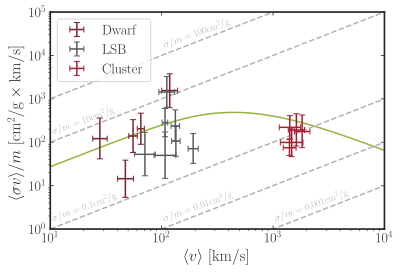

In [4]:
"""
//////////// Plots ////////////
"""

v_array = np.logspace(1, 4, 100)
v0 = v_array*np.sqrt(np.pi)/4

sigvm_array = np.zeros(100)

for i in range(100):
    sigvm_array[i] = sigv_T(v0[i], Params_fit[0], Params_fit[1], Params_fit[2])
    
# Plot Best Fit

#Model Plot
plt.plot(v_array, sigvm_array, color=MainColor1)

rot = 20
#Cross section diagonals
plt.plot(v_array, 0.001*v_array, color=Gray2, linestyle='dashed')
plt.text(1000, 1.5, r'$ \sigma/m = 0.001 \mathrm{cm^2/g}$', size=10, rotation= rot, color=Gray2)
plt.plot(v_array, 0.01*v_array, color=Gray2, linestyle='dashed')
plt.text(100, 1.5, r'$ \sigma/m = 0.01 \mathrm{cm^2/g}$', size=10, rotation= rot,color=Gray2)
plt.plot(v_array, 0.1*v_array, color=Gray2, linestyle='dashed')
plt.text(10, 1.5, r'$ \sigma/m = 0.1 \mathrm{cm^2/g}$', size=10, rotation= rot, color=Gray2)
plt.plot(v_array, 10*v_array, color=Gray2, linestyle='dashed')
plt.text(10, 150, r'$ \sigma/m = 10 \mathrm{cm^2/g}$', size=10, rotation= rot, color=Gray2)
plt.plot(v_array, 100*v_array, color=Gray2, linestyle='dashed')
plt.text(100, 1.5e4, r'$ \sigma/m = 100 \mathrm{cm^2/g}$', size=10, rotation= rot, color=Gray2)

#Data
plt.errorbar(Dwarf_x, Dwarf_y, (Dwarf_Err_d, Dwarf_Err_u), (Dwarf_Err_l, Dwarf_Err_r), ls='', color=BackgroundColor2, capsize=3, label='Dwarf')
plt.errorbar(Galaxy_x, Galaxy_y, (Galaxy_Err_d, Galaxy_Err_u), (Galaxy_Err_l, Galaxy_Err_r), ls='', color=Gray1, capsize=3, label='LSB')
plt.errorbar(Cluster_x, Cluster_y, (Cluster_Err_d, Cluster_Err_u), (Cluster_Err_l, Cluster_Err_r), ls='', color=MainColor2, capsize=3, label='Cluster')

#Settings
plt.tick_params(top=True, right=True, direction='in')
plt.xlabel(r'$\langle v \rangle ~[ \mathrm{km/s}]$')
plt.ylabel(r'$\langle\sigma v \rangle /m ~[\mathrm{cm^2/g \times km/s}]$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1, 1e5)
plt.xlim(10, 1e4)
plt.legend()
plt.savefig(Thesis_path+'DarkMatter/DarkMatterPlots/GalaxyFit.pdf')
plt.savefig(Thesis_path+'DarkMatter/DarkMatterPlots/GalaxyFit.svg')
plt.show()
